### 查看数据

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

In [11]:
data_path = '../data/PRSA_data_2010.1.1-2014.12.31.csv'

def parse(x):
    return datetime.strptime(x,'%Y %m %d %H')

df = pd.read_csv(data_path,parse_dates = [['year','month','day','hour']])

In [12]:
df.head()

,year_month_day_hour,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,2010 1 1 0,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2010 1 1 1,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,2010 1 1 2,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,2010 1 1 3,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,2010 1 1 4,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [17]:
df['date'] = df['year_month_day_hour'].apply(parse)

In [18]:
df.head()

,year_month_day_hour,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date
0,2010 1 1 0,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,2010 1 1 1,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,2010 1 1 2,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,2010 1 1 3,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,2010 1 1 4,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


In [24]:
#df.drop(columns = ['No','year_month_day_hour'],inplace = True)
df.set_index(['date'],inplace=True)
df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [25]:
df.columns = ['pollution','dew','temp','press','wnd_dir','wnd_spd','snow','rain']
df['pollution'].fillna(0,inplace=True)

In [26]:
'''
    对待数据列名的描述
    date:日期
    pollution:PM2.5浓度
    dew:露点
    temp:温度
    press:气压
    wnd_dir：组合风向
    wnd_spd:累计风速
    snow:累计降雪时间
    rain:累计降雨时间
'''
df.to_csv('../data/pollution.csv')

In [27]:
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,NW,12.97,0,0


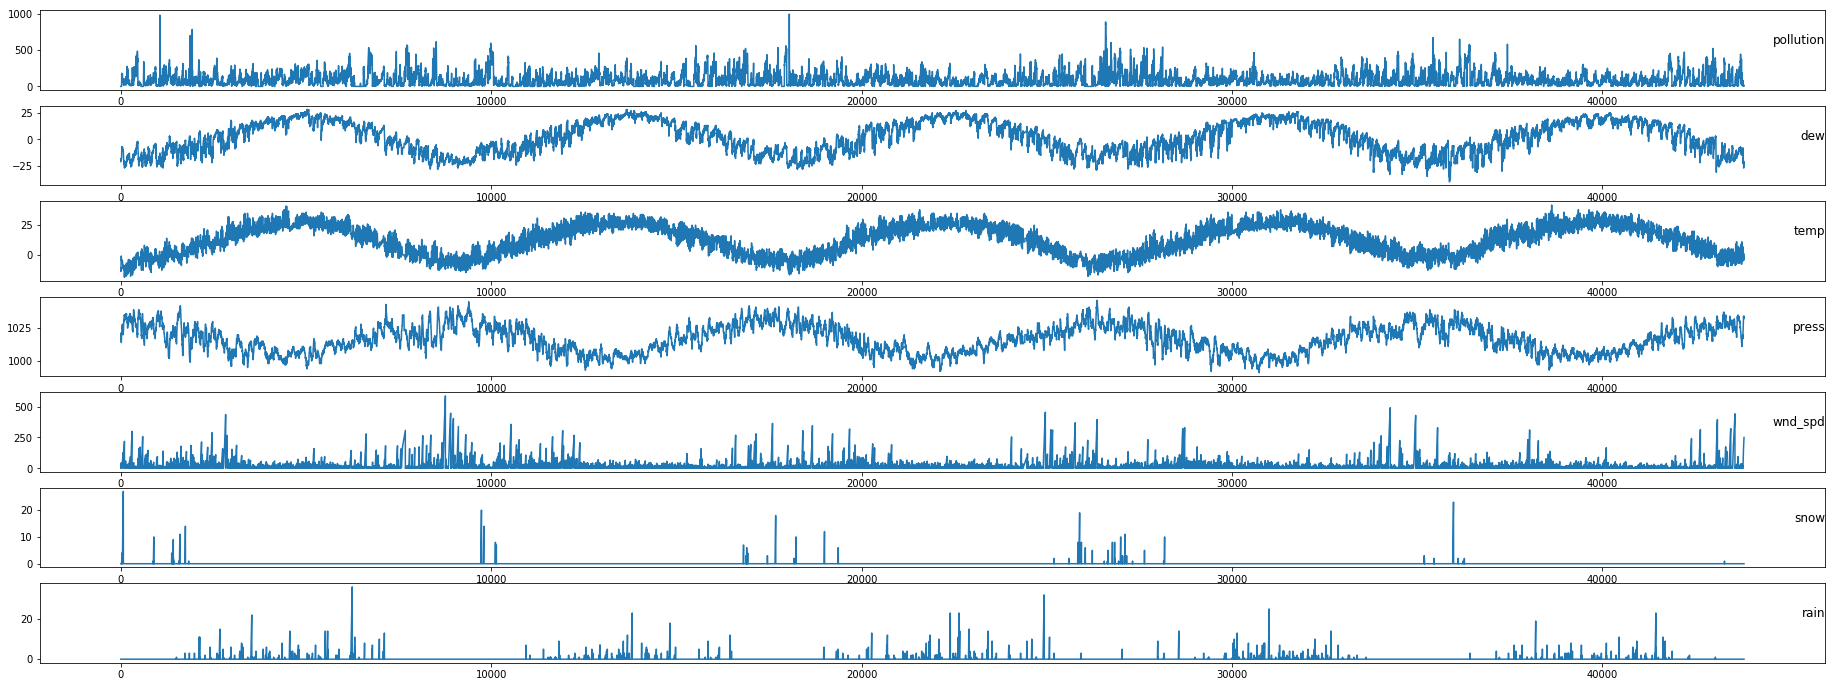

In [34]:
# 为每个参数绘制单独的子图
values = df.values
groups = [0,1,2,3,5,6,7]
i = 1
plt.figure()
plt.rcParams['figure.figsize'] = (24.0, 12.0) 
for group in groups:
    plt.subplot(len(groups),1,i)
    plt.plot(values[:,group])
    plt.title(df.columns[group],y=0.5,loc='right')
    i += 1
plt.show()

## 不考虑lagging特征进行预测

In [36]:
# 正常的时间序列需要考虑lagging特征，但是现在为了学习lstm预测时间序列的问题，先摸清流程
rnn_unit = 10
input_size = 4
output_size = 1
lr = 0.0006
tf.reset_default_graph()

#输入层、输出层权重、偏置
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
         }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
        }


In [ ]:
# 分割数据集
def get_data(batch_size,time_step=20,train_begin = 0,train_end = 487):
    batch_index = []
    
    scaler_for_x=MinMaxScaler(feature_range=(0,1))  #按列做minmax缩放
    scaler_for_y=MinMaxScaler(feature_range=(0,1))
    scaled_x_data=scaler_for_x.fit_transform(data[:,:-1])
    scaled_y_data=scaler_for_y.fit_transform(data[:,-1])
